### Vectorize and Visualization

In [23]:
import re
import time
import nltk
import string
import matplotlib
import collections
%matplotlib inline
import numpy as np
import pandas as pd 
from nltk import map_tag
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.model_selection import StratifiedShuffleSplit
from nltk import sent_tokenize,word_tokenize,pos_tag, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [24]:
data = pd.read_csv("../input/imdb.csv") # read the data
data_for_analize = pd.read_csv("../input/imdb.csv",header=None) # read the data for analize

/Users/Sina/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
data = shuffle(data)
#data = data[0:1000]

In [26]:
genre = data.drop(['TITLE', 'SUMMARY'], axis=1)
summary = data['SUMMARY']
title = data['TITLE']

In [27]:
print('shape of genres ',genre.shape)
print('shape of summary ',summary.shape)
print('shape of title ',title.shape)

shape of genres  (301134, 28)
shape of summary  (301134,)
shape of title  (301134,)


In [28]:
save_path = '../vectors/all/'

## Visualization

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301134 entries, 210856 to 292258
Data columns (total 30 columns):
Reality-TV     301134 non-null int64
Musical        301134 non-null int64
Horror         301134 non-null int64
Comedy         301134 non-null int64
News           301134 non-null int64
Talk-Show      301134 non-null int64
War            301134 non-null int64
Family         301134 non-null int64
Action         301134 non-null int64
Drama          301134 non-null int64
Adventure      301134 non-null int64
Adult          301134 non-null int64
Crime          301134 non-null int64
Mystery        301134 non-null int64
Sport          301134 non-null int64
Documentary    301134 non-null int64
Thriller       301134 non-null int64
Biography      301134 non-null int64
Animation      301134 non-null int64
Fantasy        301134 non-null int64
Romance        301134 non-null int64
Western        301134 non-null int64
Film-Noir      301134 non-null int64
Short          301134 non-null in

### genre distribution

In [30]:
no_of_genre= data_for_analize.as_matrix()[1:,0:28]

for i in range(len(no_of_genre)):
    for j in range(len(no_of_genre[0])):
        no_of_genre[i][j] = int(no_of_genre[i][j])

In [31]:
a0 = 0
a1 = 0
a2=0
a3=0
a4=0
a5=0
aplus = 0
for i in range(len(no_of_genre)):
    if sum(no_of_genre[i])==0:
        a0+=1
    elif sum(no_of_genre[i])==1:
        a1+=1
    elif sum(no_of_genre[i])==2:
        a2+=1
    elif sum(no_of_genre[i])==3:
        a3+=1
    elif sum(no_of_genre[i])==4:
        a4+=1
    elif sum(no_of_genre[i])==5:
        a5+=0
    else:
        aplus+=1



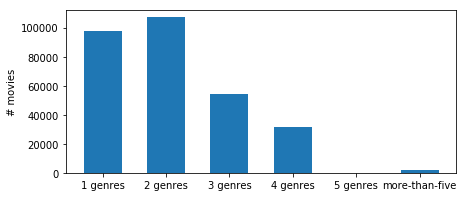

In [32]:
key = ['1 genres', '2 genres','3 genres','4 genres','5 genres','more-than-five']
values = [a1,a2,a3,a4,a5,aplus]
plt.figure(figsize=(7,3))

res1= plt.bar(key, values, 0.6)
plt.ylabel('# movies')
plt.show()
plt.savefig('distribution.png')


### Number of movies per genre

In [33]:
counts = []
categories = list(genre.columns.values)
for i in categories:
    counts.append((i, genre[i].sum()))
data_stats= pd.DataFrame(counts, columns=['genre', 'movies'])
data_stats

,genre,movies
0,Reality-TV,2494
1,Musical,5680
2,Horror,19316
3,Comedy,71359
4,News,4941
5,Talk-Show,927
6,War,7394
7,Family,20543
8,Action,24810
9,Drama,117906


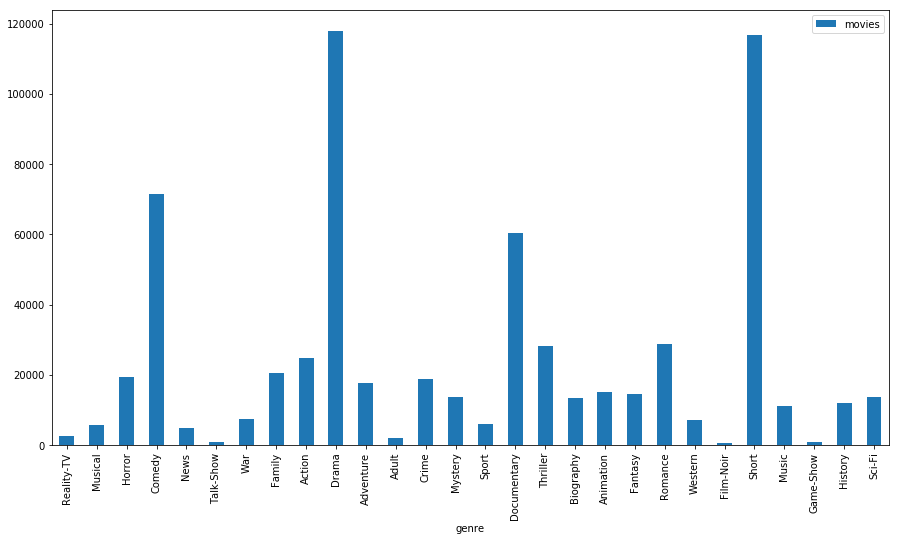

In [34]:
data_stats.plot(x='genre', y='movies', kind="bar",figsize=(15, 8))

Since Talk-Show, Adult, Film-Noir and Game show have very small number of movies, maybe it is usefull to delete them from our genre. So we will generate another genre dataframe without these genres

In [35]:
balanced_genre = genre.drop('Talk-Show', 1)
balanced_genre = balanced_genre.drop('Adult',1)
balanced_genre = balanced_genre.drop('Film-Noir',1)
balanced_genre = balanced_genre.drop('Game-Show',1)

In [36]:
print('shape of balanced_genre',balanced_genre.shape)

shape of balanced_genre (301134, 24)


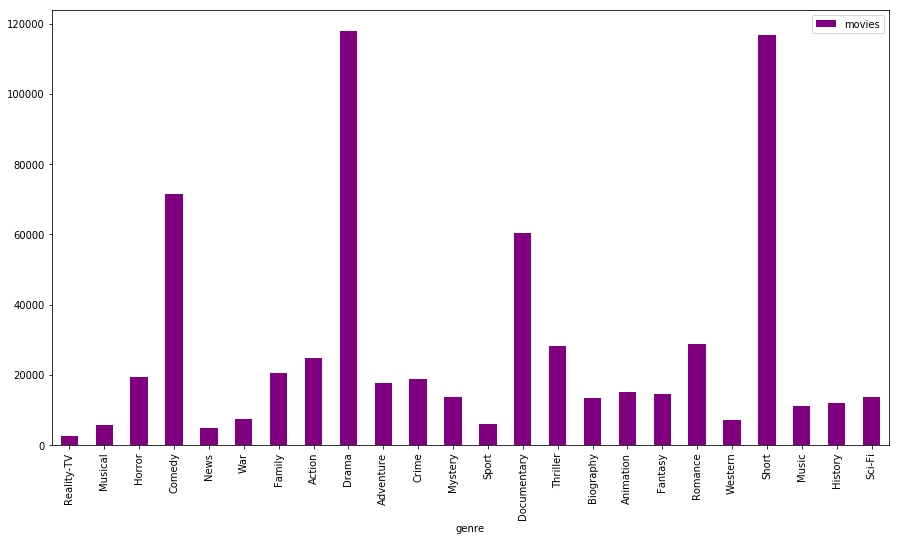

In [37]:
counts = []
categories = list(balanced_genre.columns.values)
for i in categories:
    counts.append((i, balanced_genre[i].sum()))
data_stats= pd.DataFrame(counts, columns=['genre', 'movies'])
data_stats.plot(x='genre', y='movies', kind="bar",figsize=(15, 8),color='purple')

#### Average  genre of a movie

In [38]:
a = 0
for idx,i in enumerate(genre):
    a =a+ sum(genre[i])    
c = a/genre.shape[0]
print('Each movie belongs on average to ', c ,' genre',)

Each movie belongs on average to  2.1792225388  genre


#### Top 20 Most Frequent label occurrence

In [41]:
data_for_analize_distinct= data_for_analize.as_matrix()[1:,0:28]
d = collections.OrderedDict()
for a in data_for_analize_distinct:
 t = tuple(a)
 if t in d:
  d[t] += 1
 else:
  d[t] = 1

result = []
for key, value in d.items():
 result.append(list(key) + [int(value)])

B = np.asarray(result)

a=[]
f = []
for i in range(len(B)):
    for j in range(len(B[0])):
        a.append(int(B[i][j]))
    f.append(a)
    a = []  
    
f = sorted(f,key=lambda x: x[-1])
f.reverse()
distinct_label_ocu = np.asarray(f)
temp = pd.DataFrame(distinct_label_ocu[0:10,0:28])
distinct_label = temp

In [60]:
tmp = data_for_analize.as_matrix()

len(tmp)

301135

In [63]:
tmp = data_for_analize.as_matrix()
data_dict_first10 = []
for i in range(1,len(tmp)):
    for j in range(len(v)):
        if sum(tmp[i,0:28] -v[j]) ==0:
            data_dict_first10.append(tmp[i])
            break;
data_dict_first10 = pd.DataFrame(data_dict_first10) #data_dict_first20 is a new data which has only top 20 genre occurance
data_dict_first10.columns = list(data.columns.values) 

In [64]:
top10_genre = data_dict_first10.drop(['TITLE', 'SUMMARY'], axis=1)
top10_summary = data_dict_first10['SUMMARY']
top10_title = data_dict_first10['TITLE']

In [65]:
print('shape of top10_genre ',top10_genre.shape)
print('shape of top10_summary ',top10_summary.shape)
print('shape of top10_title ',top10_title.shape)

shape of top10_genre  (204576, 28)
shape of top10_summary  (204576,)
shape of top10_title  (204576,)


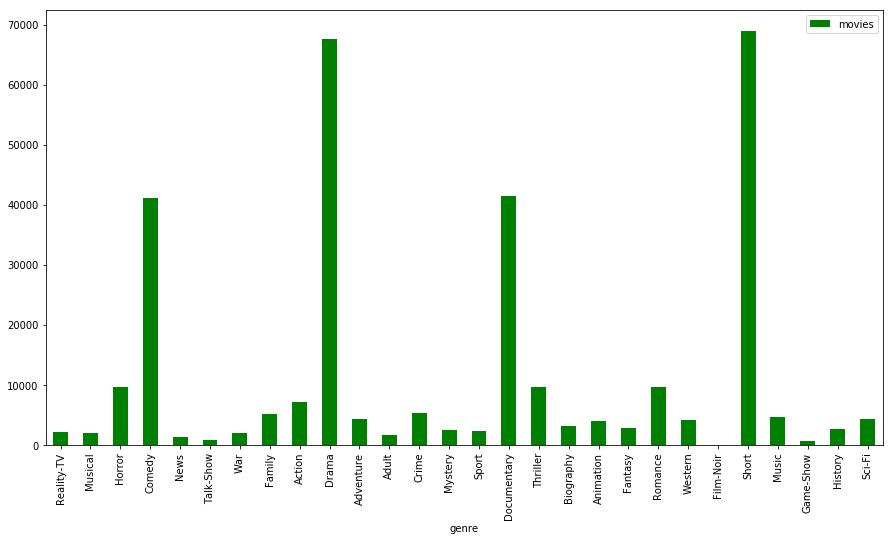

In [66]:
counts = []
categories = list(top10_genre.columns.values)
for i in categories:
    counts.append((i, top10_genre[i].sum()))
data_stats= pd.DataFrame(counts, columns=['genre', 'movies'])
data_stats.plot(x='genre', y='movies', kind="bar",figsize=(15, 8),color='green')

# Vectorize

### tokenizing

In [67]:
stpwds = stopwords.words('english')

##### Usefull functions

In [68]:
def clean_POS(x ,my_stopwords, remove_stopwords=True,stemming = False):
    
    sentences = sent_tokenize(x)
    sents = []
    for s in sentences:
        text = word_tokenize(s)
        #text= text.lower()
        #text= [X.lower() for X in text]
        if remove_stopwords:
            text = [token for token in text if token not in my_stopwords]
        if stemming:
            stemmer = nltk.stem.PorterStemmer()
            tokens_stemmed = list()
            for token in text:
                tokens_stemmed.append(stemmer.stem(token))
            text = tokens_stemmed
            
        pos_tagged = pos_tag(text)
        simplified_tags = [
            (word, map_tag('en-ptb', 'universal', tag)) for word, tag in pos_tagged]
        sents.append(simplified_tags)
       
    return sents

In [69]:
def post_tag_documents(X,y,stem = False):
    X = X.as_matrix().tolist()
    y= y.as_matrix()
    stpwds = stopwords.words('english')
    x_data = []
    y_data = []
    total = len(X)
    plots = X
    genres = y
    for i in range(len(plots)):
        plot = plots[i]
        #plot = plots.replace("-"," ")
        plot = re.sub(' +',' ',plot) # strip extra white space
        plot = re.sub("[^a-zA-Z ! ?]","", plot)
        plot = plot.strip()
        sents = clean_POS(plot,stpwds,stemming=stem)
        x_data.append(sents)
        y_data.append(genres[i])
        i += 1
        if i % 5000 == 0:
            print (i, "/", total)

    return x_data, y_data

### Word2Vec

In [70]:
google_vecs = KeyedVectors.load_word2vec_format('../input/GoogleNews-vectors-negative300.bin', binary=True) #google pretrained Vector

In [72]:
t = time.time()
word_and_label = post_tag_documents(summary,genre)

print('Tokenizing took: ', time.time()-t , 'seconds')

5000 / 301134
10000 / 301134
15000 / 301134
20000 / 301134
25000 / 301134
30000 / 301134
35000 / 301134
40000 / 301134
45000 / 301134
50000 / 301134
55000 / 301134
60000 / 301134
65000 / 301134
70000 / 301134
75000 / 301134
80000 / 301134
85000 / 301134
90000 / 301134
95000 / 301134
100000 / 301134
105000 / 301134
110000 / 301134
115000 / 301134
120000 / 301134
125000 / 301134
130000 / 301134
135000 / 301134
140000 / 301134
145000 / 301134
150000 / 301134
155000 / 301134
160000 / 301134
165000 / 301134
170000 / 301134
175000 / 301134
180000 / 301134
185000 / 301134
190000 / 301134
195000 / 301134
200000 / 301134
205000 / 301134
210000 / 301134
215000 / 301134
220000 / 301134
225000 / 301134
230000 / 301134
235000 / 301134
240000 / 301134
245000 / 301134
250000 / 301134
255000 / 301134
260000 / 301134
265000 / 301134
270000 / 301134
275000 / 301134
280000 / 301134
285000 / 301134
290000 / 301134
295000 / 301134
300000 / 301134
Tokenizing took:  1392.8032541275024 seconds


In [73]:
x_data = word_and_label[0] # tokenized x_data  for example : ('With', 'ADP'),('fallout', 'ADJ')
y_data = word_and_label[1]# labels

In [74]:
def word2vec(x_data, pos_filter,vector):

    print ("Loading GoogleNews-vectors-negative300.bin")
    google_vecs = vector
    print ("GoogleNews-vectors-negative300.bin loaded")
    print ("Considering only", pos_filter)
    print ("Averaging Word Embeddings...")
    x_data_embeddings = []
    total = len(x_data)
    processed = 0
    false_count=0
    for tagged_plot in x_data:
        count = 0
        doc_vector = np.zeros(300)
        for sentence in tagged_plot:
            for tagged_word in sentence:
                if tagged_word[1] in pos_filter:
                    try:
                        doc_vector += google_vecs[tagged_word[0]]
                        count += 1
                    except KeyError:
                        false_count+=1
                        continue
                        

        doc_vector /= count
        if np.isnan(np.min(doc_vector)):
            continue

        x_data_embeddings.append(doc_vector)

        processed += 1
        if processed % 10000 == 0:
            print (processed, "/", total)
    print('Word Embeddings Done')        
    return np.array(x_data_embeddings)

In [75]:
t = time.time()

pos_filter = ['NOUN', 'ADJ','VERB'] # maybe we can add 'PRT','ADV' and others too
x_embeddings = word2vec(x_data, pos_filter,google_vecs)# get embeddings for train and test data

print('word2vec took ', time.time()-t,' seconds' )

print('Shape of x_embeddings',x_embeddings.shape)

Loading GoogleNews-vectors-negative300.bin
GoogleNews-vectors-negative300.bin loaded
Considering only ['NOUN', 'ADJ', 'VERB']
Averaging Word Embeddings...
10000 / 301134
20000 / 301134
30000 / 301134
40000 / 301134
50000 / 301134
60000 / 301134
70000 / 301134
80000 / 301134
90000 / 301134
100000 / 301134
110000 / 301134
120000 / 301134
130000 / 301134
140000 / 301134
150000 / 301134
160000 / 301134
170000 / 301134
180000 / 301134
190000 / 301134
200000 / 301134
210000 / 301134
220000 / 301134
230000 / 301134
240000 / 301134
250000 / 301134
260000 / 301134
270000 / 301134
280000 / 301134
290000 / 301134
300000 / 301134
Word Embeddings Done
word2vec took  551.3431630134583  seconds
Shape of x_embeddings (301134, 300)


Now we can store our x_embeding and labels for train and test

In [76]:
x_embeddings = pd.DataFrame(x_embeddings)
y = pd.DataFrame(y_data)

x_embeddings.to_csv(save_path+'word2vec/x_embeddings_Word2Vec.csv', index=False)
y.to_csv(save_path+'word2vec/y_data_Word2Vec.csv', index=False)

### Word2Vec top 20  dictinct Genre 

In [77]:
word_and_label = post_tag_documents(top10_summary,top10_genre)#top20_title

5000 / 204576
10000 / 204576
15000 / 204576
20000 / 204576
25000 / 204576
30000 / 204576
35000 / 204576
40000 / 204576
45000 / 204576
50000 / 204576
55000 / 204576
60000 / 204576
65000 / 204576
70000 / 204576
75000 / 204576
80000 / 204576
85000 / 204576
90000 / 204576
95000 / 204576
100000 / 204576
105000 / 204576
110000 / 204576
115000 / 204576
120000 / 204576
125000 / 204576
130000 / 204576
135000 / 204576
140000 / 204576
145000 / 204576
150000 / 204576
155000 / 204576
160000 / 204576
165000 / 204576
170000 / 204576
175000 / 204576
180000 / 204576
185000 / 204576
190000 / 204576
195000 / 204576
200000 / 204576


In [78]:
x_data = word_and_label[0] # tokenized x_data  for example : ('With', 'ADP'),('fallout', 'ADJ')
y_data = word_and_label[1]

In [79]:
t= time.time()
pos_filter = ['NOUN', 'ADJ','VERB'] # maybe we can add 'PRT','ADV' and others too
x_embeddings = word2vec(x_data, pos_filter,google_vecs)# get embeddings for train and test data

print('word2vec Top20 took ', time.time()-t,' seconds' )
print('Shape of x_embeddings',x_embeddings.shape)

Loading GoogleNews-vectors-negative300.bin
GoogleNews-vectors-negative300.bin loaded
Considering only ['NOUN', 'ADJ', 'VERB']
Averaging Word Embeddings...
10000 / 204576
20000 / 204576
30000 / 204576
40000 / 204576
50000 / 204576
60000 / 204576
70000 / 204576
80000 / 204576
90000 / 204576
100000 / 204576
110000 / 204576
120000 / 204576
130000 / 204576
140000 / 204576
150000 / 204576
160000 / 204576
170000 / 204576
180000 / 204576
190000 / 204576
200000 / 204576
Word Embeddings Done
word2vec Top20 took  153.5524821281433  seconds
Shape of x_embeddings (204576, 300)


In [80]:
x_embeddings = pd.DataFrame(x_embeddings)
y = pd.DataFrame(y_data)

x_embeddings.to_csv(save_path+'word2vectop10/x_embeddings_Word2Vec_top10.csv', index=False)
y.to_csv(save_path+'word2vectop10/y_data_Word2Vec_top10.csv', index=False)

### Doc2Vec

### In Doc2Vec and bag of words we should split our train and test data before vectorizing because test data shouln't have influence on our Doc2Vec and bag of words models

### Tokenize for Doc2Vec and bag of words

In [81]:
pos_filter = ['NOUN', 'ADJ','VERB'] # maybe we can add 'PRT','ADV' and others too

In [82]:
msk = int(len(data)*70/100)


genre_train = genre[0:msk]
summary_train = summary[0:msk]
title_train = title[0:msk].as_matrix()


genre_test = genre[msk:]
summary_test = summary[msk:]
title_test = title[msk:].as_matrix()


print('size of train data : ',summary_train.shape[0])
print('size of test data : ',summary_test.shape[0])

size of train data :  210793
size of test data :  90341


In [83]:
word_and_label_stemmed_train = post_tag_documents(summary_train,genre_train,stem=True) #stemmming changed to true for Doc2Vec
word_and_label_stemmed_test = post_tag_documents(summary_test,genre_test,stem=True) #***stem=true***

x_data_stemmed_train = word_and_label_stemmed_train[0] # tokenized x_data  for example : ('With', 'ADP'),('fallout', 'ADJ')
y_data_stemmed_train = word_and_label_stemmed_train[1] # labels

x_data_stemmed_test = word_and_label_stemmed_test[0] # tokenized x_data  for example : ('With', 'ADP'),('fallout', 'ADJ')
y_data_stemmed_test = word_and_label_stemmed_test[1] # labels


5000 / 210793
10000 / 210793
15000 / 210793
20000 / 210793
25000 / 210793
30000 / 210793
35000 / 210793
40000 / 210793
45000 / 210793
50000 / 210793
55000 / 210793
60000 / 210793
65000 / 210793
70000 / 210793
75000 / 210793
80000 / 210793
85000 / 210793
90000 / 210793
95000 / 210793
100000 / 210793
105000 / 210793
110000 / 210793
115000 / 210793
120000 / 210793
125000 / 210793
130000 / 210793
135000 / 210793
140000 / 210793
145000 / 210793
150000 / 210793
155000 / 210793
160000 / 210793
165000 / 210793
170000 / 210793
175000 / 210793
180000 / 210793
185000 / 210793
190000 / 210793
195000 / 210793
200000 / 210793
205000 / 210793
210000 / 210793
5000 / 90341
10000 / 90341
15000 / 90341
20000 / 90341
25000 / 90341
30000 / 90341
35000 / 90341
40000 / 90341
45000 / 90341
50000 / 90341
55000 / 90341
60000 / 90341
65000 / 90341
70000 / 90341
75000 / 90341
80000 / 90341
85000 / 90341
90000 / 90341


In [84]:
def tagged_document(X,lab,pos_filter):
    i = 0
    tag = []
    document = []
    for tagged_plot in X:
        label = ["_".join(lab[i].split())]
        i +=1
        for sentence in tagged_plot:
            for tagged_word in sentence:
                if tagged_word[1] in pos_filter:
                    document.append(tagged_word[0])
        
        doc = TaggedDocument(document, label)
        tag.append(doc)
        document = []
        
    return tag

In [85]:
train_tag=tagged_document(x_data_stemmed_train,title_train,pos_filter)
test_tag = tagged_document(x_data_stemmed_test,title_test,pos_filter)

### ## Doc2Vec Vectorize

In [86]:
def doc2vec(traintag,testtag):

    data = traintag
    model = Doc2Vec(min_count=1, window=10, size=300, sample=1e-3,alpha=0.025, negative=7, workers=4)
    print ("Building Vocabulary")
    model.build_vocab(data)

    for epoch in range(11):
        if epoch%5==0: 
            print ("Training epoch %s" % epoch)
        model.train(data, total_examples=model.corpus_count , epochs=model.iter)
        model.alpha -= 0.002  # decrease the learning rate
        model.min_alpha = model.alpha  # fix the learning rate, no decay
        model.train(data, total_examples=model.corpus_count, epochs=model.iter)

        
    model.save("model.Doc2Vec")
    x_data = []
    for doc_id in range(len(traintag)):
        inferred_vector = model.docvecs[doc_id]
        x_data.append(inferred_vector)

    x_test = []
    for doc_id in range(len(testtag)):
        inferred_vector = model.infer_vector(testtag[doc_id].words)
        x_test.append(inferred_vector)

    
    
    return np.array(x_data), np.array(x_test)


In [87]:
t = time.time()
x_emb_train,x_emb_test = doc2vec(train_tag,test_tag)

print('Doc2Vec took', time.time()-t , 'Seconds' )

Building Vocabulary
Training epoch 0
Training epoch 5
Training epoch 10
Doc2Vec took 3856.86718082428 Seconds


In [88]:
x_data_train = pd.DataFrame(x_emb_train)
y_data_train = pd.DataFrame(genre_train)
x_data_test = pd.DataFrame(x_emb_test)
y_data_test = pd.DataFrame(genre_test)

print('x_data_train: ',x_data_train.shape)
print('x_data_test: ',x_data_test.shape)
print('y_data_train: ',y_data_train.shape)
print('y_data_test: ',y_data_test.shape)

## save for later .....
x_data_train.to_csv(save_path+'doc2vec/x_data_train_doc2vec.csv', index=False)
y_data_train.to_csv(save_path+'doc2vec/y_data_train_doc2vec.csv',index=False)
x_data_test.to_csv(save_path+'doc2vec/x_data_test_doc2vec.csv', index=False)
y_data_test.to_csv(save_path+'doc2vec/y_data_test_doc2vec.csv',index=False)

x_data_train:  (210793, 300)
x_data_test:  (90341, 300)
y_data_train:  (210793, 28)
y_data_test:  (90341, 28)


## Bag Of Words and TF-IDF

#### decrease data size

In [89]:
dec_train_tag = train_tag[0:20000]
dec_test_tag = test_tag[0:8000]



#### To run this section we have to first run section --Tokenize for Doc2Vec and bag of words--

In [90]:
def to_sentence(TaggedDocuments):
    doc = TaggedDocuments[0]
    doc = "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in doc]).strip()
    return doc

In [91]:
vectorizer = CountVectorizer()

In [92]:
t = time.time()
X = []
for i in range(len(dec_train_tag)):
    X.append(to_sentence(dec_train_tag[i]))
x_train = vectorizer.fit_transform(X).toarray()

print('Bag of words took ', time.time()-t , ' Seconds' )

Bag of words took  3.093120813369751  Seconds


In [93]:
X = []
for i in range(len(dec_test_tag)):
    X.append(to_sentence(dec_test_tag[i]))
x_test = vectorizer.transform(X).toarray() 

In [94]:
x_data_train = pd.DataFrame(x_train)
y_data_train = pd.DataFrame(genre_train[0:20000])
x_data_test = pd.DataFrame(x_test)
y_data_test = pd.DataFrame(genre_test[0:8000])

print('x train: ',x_data_train.shape)
print('y train: ',y_data_train.shape)
print('x test: ',x_data_test.shape)
print('y test: ',y_data_test.shape)

## save .....
x_data_train.to_csv(save_path+'bagofword/x_data_train_bagofwords.csv', index=False)
y_data_train.to_csv(save_path+'bagofword/y_data_train_bagofwords.csv',index=False)
x_data_test.to_csv(save_path+'bagofword/x_data_test_bagofwords.csv', index=False)
y_data_test.to_csv(save_path+'bagofword/y_data_test_bagofwords.csv',index=False)

x train:  (20000, 51053)
y train:  (20000, 28)
x test:  (8000, 51053)
y test:  (8000, 28)


## TF_IDF

In [95]:
vectorizer = TfidfVectorizer()

In [96]:
t = time.time()

X = []
for i in range(len(dec_train_tag)):
    X.append(to_sentence(dec_train_tag[i]))
x_train = vectorizer.fit_transform(X).toarray()

print('TF-IDF took', time.time()-t , 'Seconds' )

TF-IDF took 4.847495079040527 Seconds


In [97]:
X = []
for i in range(len(dec_test_tag)):
    X.append(to_sentence(dec_test_tag[i]))
x_test = vectorizer.transform(X).toarray() 

In [98]:
x_data_train = pd.DataFrame(x_train)
y_data_train = pd.DataFrame(genre_train[0:20000])
x_data_test = pd.DataFrame(x_test)
y_data_test = pd.DataFrame(genre_test[0:8000])

print('x train: ',x_data_train.shape)
print('y train: ',y_data_train.shape)
print('x test: ',x_data_test.shape)
print('y test: ',y_data_test.shape)

## save .....
x_data_train.to_csv(save_path+'tfidf/x_data_train_tfidf.csv', index=False)
y_data_train.to_csv(save_path+'tfidf/y_data_train_tfidf.csv',index=False)
x_data_test.to_csv(save_path+'tfidf/x_data_test_tfidf.csv', index=False)
y_data_test.to_csv(save_path+'tfidf/y_data_test_tfidf.csv',index=False)

x train:  (20000, 51053)
y train:  (20000, 28)
x test:  (8000, 51053)
y test:  (8000, 28)
